grid of mod std vs obs std plots. horizontal = frequency band; vertical = variable

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import pandas as pd
from Tools import commonfxns as cf, OAPBuoyData as OAP, mplRC, OAPBuoyComp as bc,viz, evalfxns as ev, \
    frequencyBands as fb
import netCDF4 as nc
import cftime
import datetime as dt
import cmocean
import gsw
#from sklearn.linear_model import TheilSenRegressor
import pickle
import os
import matplotlib as mpl
from IPython.display import Markdown, display, HTML
import astropy.timeseries as apt
from collections import OrderedDict
import warnings
from matplotlib.colors import ListedColormap

mplRC.paperRC2()

In [2]:
import matplotlib.ticker as mtick
mtick.AutoLocator.__init__ = lambda self: mtick.MaxNLocator.__init__(self,nbins='auto',steps=[1,2,2.5,3,5,10])

In [3]:
# need to add hplus
varlist=['tos','sos',] # need to add ,'hplus'
Tvec=[7,31,365]
freq='daily'

In [4]:
fb.bxfbase

'/work/ebo/calcs/buoyCompTS/bxfs/'

In [5]:
dfHD=pd.read_csv(fb.bxfbase+f"bxf_df.{'_'.join([str(el) for el in Tvec])}.{freq}.HDgrid.csv")
df1=pd.read_csv(fb.bxfbase+f"bxf_df.{'_'.join([str(el) for el in Tvec])}.{freq}.csv")

In [42]:
def _num2str(bb,ivar):
    if ivar in ['phos']:
        return f"{bb:.3f}"
    elif ivar in ['sos','chlos']:
        return f"{bb:.2f}"
    elif ivar in ['tos','apco2']:
        return f"{bb:.1f}"
    elif ivar in ['spco2','o2os','AOUos']:
        return f"{bb:.0f}"
    else:
        return f"{bb:.3f}"
def makeplot3rowModMod(varlist,df1,dfHD):
    df=dfHD
    #T,S
    ms=12
    mso=4
    fs=10
    cm2=cmocean.cm.deep
    numcols=len(Tvec)+1+3
    hratios=np.ones(len(varlist))#; hratios[0]=.0001
    wratios=np.ones(numcols); wratios[0]=.1
    fig,ax=plt.subplots(len(varlist),numcols,figsize=(13,.23+1.7*len(varlist)),
                        gridspec_kw=dict(width_ratios=wratios,height_ratios=hratios,wspace=.33,hspace=.16))
    for jj,ivar in enumerate(varlist):
        axmax=0
        axmaxL=0
        if ivar in bc.varUncert.keys():
            unc=bc.varUncert[ivar]
        else:
            unc=np.nan
        for ii, group in enumerate([('vards_1_7_obs','vards_1_7_mod','vards_1_7_obs_N'),
                                    ('vards_7_31_obs','vards_7_31_mod','vards_7_31_obs_N'),
                                    ('vards_31_365_obs','vards_31_365_mod','vards_31_365_obs_N'),
                                    ('vards_g365_obs','vards_g365_mod','vards_g365_obs_N'),
                                    ('var_seas_obs','var_seas_mod','vards_g365_obs_N'),
                                    ('var_total_obs','var_total_mod','var_total_obs_N')]):
            idf=df1.loc[(df1.ivar==ivar)&(~pd.isnull(df1[group[0]]))&(~pd.isnull(df1[group[1]]))]
            idfHD=dfHD.loc[(dfHD.ivar==ivar)&(~pd.isnull(dfHD[group[0]]))&(~pd.isnull(dfHD[group[1]]))]
            m=ax[jj,ii+1].scatter(np.sqrt(idfHD[group[1]]),np.sqrt(idf[group[1]]),
                          c=idf['modBathy'],s=ms,cmap=cm2,vmin=0,vmax=4000,
                                        marker='o',edgecolors='k',linewidth=.5)
            R=np.corrcoef(np.sqrt(idfHD[group[1]].values),np.sqrt(idf[group[1]].values))[1,0]
            bb=np.mean(np.sqrt(idf[group[1]].values)-np.sqrt(idfHD[group[1]].values))
            #ax[jj,ii+1].plot(np.arange(0,100),lf.coef[0]+lf.coef[1]*np.arange(0,100),'k-',lw=1)
            ax[jj,ii+1].text(.015, .885, 'R$=$'+f"{R:.2f}", ha='left', va='top', 
                             transform=ax[jj,ii+1].transAxes)
            ax[jj,ii+1].text(.015, .985, 'bias$=$'+_num2str(bb,ivar), ha='left', va='top', 
                             transform=ax[jj,ii+1].transAxes)
            if ii<4:
                axmax=np.max([axmax,np.max(np.sqrt(idf[group[0]])),np.max(np.sqrt(idf[group[1]]))])
                if ivar=='phos':
                    axmax2=np.max([axmax,np.max(np.sqrt(idf2[group[0]])),np.max(np.sqrt(idf2[group[1]]))])
                    axmax=max(axmax,axmax2)
            else:
                axmaxL=np.max([axmaxL,np.max(np.sqrt(idf[group[0]])),np.max(np.sqrt(idf[group[1]]))])
        for ii in range(0,len(Tvec)+3):
            axmaxi=axmax if ii<4 else axmaxL
            ax[jj,ii+1].axis([0,1.05*axmaxi,0,1.05*axmaxi])
            viz.squareax(ax[jj,ii+1],linespecs={'color':'lightgray','linewidth':1,'linestyle':':'})
            #ax[jj,ii+1].axvline(unc,color='r',linestyle=':')
        if ivar=='AOUos':
            strname='$\Delta$O$_2$ (μmol kg$^{-1}$)'
        elif ivar=='o2os':
            strname='Dissolved O$_2$\n(μmol kg$^{-1}$)'
        elif ivar=='spco2':
            strname='Surface Ocean\n pCO$_2$ (μatm)'
        elif ivar=='apco2':
            strname='Surface Air\n pCO$_2$ (μatm)'
        else:
            strname=bc.dispNameUnits[ivar]
        ax[jj,0].text(.5,.5,strname,ha='center',va='center',rotation='vertical',fontsize=fs)
        ax[jj,0].axis('off')
    cbax=fig.add_axes([.92,.25,.01,.4])
    cb=fig.colorbar(m,cax=cbax,extend='max')
    cb.set_label('Bathymetry (m)',size=fs)
    #ax[0,0].remove()
    ax[0,1].set_title('1 to 7 days',fontsize=fs)
    #ax[0,1].axis('off')
    ax[0,2].set_title('7 to 31 days',fontsize=fs)
    #ax[0,2].axis('off')
    ax[0,3].set_title('31 to 365 days',fontsize=fs)
    #ax[0,3].axis('off')
    ax[0,4].set_title('$>$ 365 days',fontsize=fs)
    #ax[0,4].axis('off')
    ax[0,5].set_title('Seasonal Cycle',fontsize=fs,pad=6)
    #ax[0,5].axis('off')
    ax[0,6].set_title('Total',fontsize=fs)
    #ax[0,6].axis('off')
    fig.suptitle("1 Degree versus 1/2 Degree Model Detrended Time Series Standard Deviation",
                 y=1.0,x=.55,fontsize=fs);
    ax[0,1].annotate("-------------------------------------- Deseasonalized, Filtered by Time Scale --------------------------------------",
                     [.327,.88],xycoords='figure fraction', 
                     ha='center',annotation_clip=False,fontsize=fs);
    return fig,ax

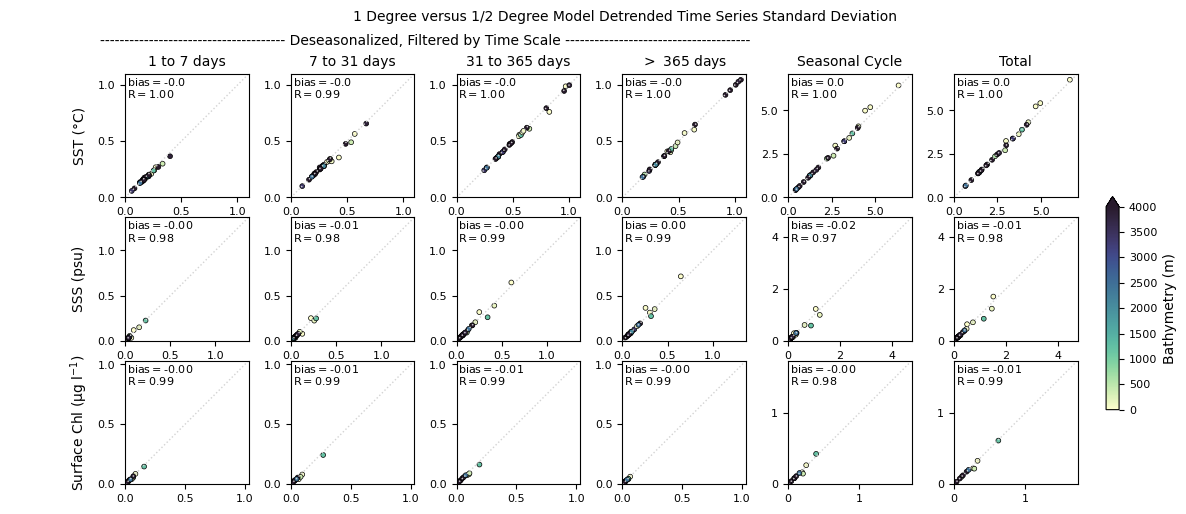

In [43]:
fig,ax=makeplot3rowModMod(['tos','sos','chlos'],df1,dfHD)
fig.savefig('/home/Elise.Olson/OAPMSE/paperFigs/bxf_1D_HD_Rev.png',dpi=300,bbox_inches='tight')